# Renta Nacional

## Cruzamos las BBDD

In [2]:
import pandas as pd
df_sc = pd.read_excel("BBDD/SC_COTIZACIONES.xlsx")
print(df_sc.head())

  FECHA_COTIZACION  NUMERO_SOLICITUD  NUMERO_IDENTIFICACION  NUMERO_SECUENCIA  \
0       2024-01-02         125720401              188965131                 1   
1       2024-01-02         125720401              188965150                 1   
2       2024-01-02         125720401              188965169                 1   
3       2024-01-02         125720401              188965188                 1   
4       2024-01-02         125747401              188975930                 1   

  TIPO_RENTA  MESES_DIFERIDOS MODALIDAD_RENTA  MESES_GARANTIZADOS  \
0          I                0               S                   0   
1          I                0               G                 120   
2          I                0               G                 192   
3          I                0               G                 180   
4          I                0               S                   0   

   MESES_AUMENTO_TEMPORAL  PORCENTAJE_AUMENTO_TEMPORAL  ...  PRIMA_UNICA  \
0                     

Cargo el otro df para tratar de cruzarlos.

In [3]:
import pandas as pd
df = pd.read_excel("BBDD/COTIZACIONES.xlsx")
print(df.head())

  FECHA_COTIZACION TIPO_PENSION TIPO_COTIZACION  COTIZANTE  COTIZACION  \
0       2024-01-02            S               E  421008240           1   
1       2024-01-02            S               E  421008240           2   
2       2024-01-02            S               E  421008240           3   
3       2024-01-02            S               E  421008240           4   
4       2024-01-02           VA               E  421005868          11   

  TIPO_INTERMEDIARIO RUT_CORREDOR TIPO_RENTA  MESES_DIFERIDOS MODALIDAD_RENTA  \
0                  S   11370691-0          I                0               S   
1                  S   11370691-0          I                0               G   
2                  S   11370691-0          I                0               G   
3                  S   11370691-0          I                0               G   
4                  S   13982859-3          I                0               G   

   ...        VAN  TASA_VAN  DURATION  DIAS_VALIDEZ  INVALIDA  TIPO_

In [43]:
print(df.columns)
print(df_sc.columns)

Index(['FECHA_COTIZACION', 'TIPO_PENSION', 'TIPO_COTIZACION', 'COTIZANTE',
       'COTIZACION', 'TIPO_INTERMEDIARIO', 'RUT_CORREDOR', 'TIPO_RENTA',
       'MESES_DIFERIDOS', 'MODALIDAD_RENTA', 'MESES_GARANTIZADOS',
       'PORCENTAJE_AUMENTO_TEMPORAL', 'MESES_AUMENTO_TEMPORAL',
       'PORCENTAJE_COMISION', 'RETIRO_EXCEDENTES', 'RETENCION_AFP',
       'PRIMA_UNICA', 'TIT', 'TIT_MAXIMA', 'CAPITAL_NECESARIO',
       'CUOTA_MORTUORIA', 'RENTA', 'VPP', 'PERDIDA', 'PORCENTAJE_PERDIDA',
       'TASA_VENTA', 'TASA_COSTO', 'TIR', 'VAN', 'TASA_VAN', 'DURATION',
       'DIAS_VALIDEZ', 'INVALIDA', 'TIPO_ERROR', 'EMITIDA', 'FECHA_RESPUESTA',
       'ACEPTADA', 'FECHA_ACEPTACION', 'MES'],
      dtype='object')
Index(['FECHA_COTIZACION', 'NUMERO_SOLICITUD', 'NUMERO_IDENTIFICACION',
       'NUMERO_SECUENCIA', 'TIPO_RENTA', 'MESES_DIFERIDOS', 'MODALIDAD_RENTA',
       'MESES_GARANTIZADOS', 'MESES_AUMENTO_TEMPORAL',
       'PORCENTAJE_AUMENTO_TEMPORAL', 'RETIRA_EXCEDENTES',
       'EXCEDENTE_SOLICITADO

Vemos si hay coincidencias.

In [4]:
print(f"Cotizantes: {len(df)}")
print(f"Cotizantes SC: {len(df_sc)}")

Cotizantes: 971410
Cotizantes SC: 962929


In [5]:
cotizantes_comunes = pd.merge(df, df_sc, on=['COTIZANTE', 'COTIZACION'], how='inner')
print(f"Cotizantes comunes: {len(cotizantes_comunes)}")

Cotizantes comunes: 962929


Verificamos que el cruce es correcto.

In [6]:
cotizantes_comunes[(cotizantes_comunes['COTIZANTE'] == 421007881) & (cotizantes_comunes['COTIZACION'] == 1)]

,FECHA_COTIZACION_x,TIPO_PENSION,TIPO_COTIZACION,COTIZANTE,COTIZACION,TIPO_INTERMEDIARIO,RUT_CORREDOR,TIPO_RENTA_x,MESES_DIFERIDOS_x,MODALIDAD_RENTA_x,...,PRIMA_UNICA_y,RETENCION_AFP_y,RETIRO_EXCEDENTES_y,INVALIDA_y,TIPO_ERROR_y,POSICION_RELATIVA,SEGMENTO,NOMBRE_SEGMENTO,TIT_PROPUESTA,TIT_MAXIMA_y
0,2024-01-02,V,A,421007881,1,NaN,NaN,I,0,S,...,730.59,0.0,0.0,0,0,2,72,V 700-800 UF,3.26,3.28


In [22]:
df[(df['COTIZANTE'] == 421007881) & (df['COTIZACION'] == 1)]

,FECHA_COTIZACION,TIPO_PENSION,TIPO_COTIZACION,COTIZANTE,COTIZACION,TIPO_INTERMEDIARIO,RUT_CORREDOR,TIPO_RENTA,MESES_DIFERIDOS,MODALIDAD_RENTA,...,VAN,TASA_VAN,DURATION,DIAS_VALIDEZ,INVALIDA,TIPO_ERROR,EMITIDA,FECHA_RESPUESTA,ACEPTADA,FECHA_ACEPTACION
5,2024-01-02,V,A,421007881,1,NaN,NaN,I,0,S,...,33.49905,3.0,113.498,12,0.0,0.0,0,NaT,0,NaT


In [23]:
df_sc[(df_sc['COTIZANTE'] == 421007881) & (df_sc['COTIZACION'] == 1)]

,FECHA_COTIZACION,NUMERO_SOLICITUD,NUMERO_IDENTIFICACION,NUMERO_SECUENCIA,TIPO_RENTA,MESES_DIFERIDOS,MODALIDAD_RENTA,MESES_GARANTIZADOS,MESES_AUMENTO_TEMPORAL,PORCENTAJE_AUMENTO_TEMPORAL,...,PRIMA_UNICA,RETENCION_AFP,RETIRO_EXCEDENTES,INVALIDA,TIPO_ERROR,POSICION_RELATIVA,SEGMENTO,NOMBRE_SEGMENTO,TIT_PROPUESTA,TIT_MAXIMA
0,2024-01-02,125720401,188965131,1,I,0,S,0,0,0,...,730.59,0.0,0.0,0,0,2,72,V 700-800 UF,3.26,3.28


### Eliminamos columnas repetidas.

In [8]:
cotizantes_comunes.columns

Index(['FECHA_COTIZACION_x', 'TIPO_PENSION', 'TIPO_COTIZACION', 'COTIZANTE',
       'COTIZACION', 'TIPO_INTERMEDIARIO', 'RUT_CORREDOR', 'TIPO_RENTA_x',
       'MESES_DIFERIDOS_x', 'MODALIDAD_RENTA_x', 'MESES_GARANTIZADOS_x',
       'PORCENTAJE_AUMENTO_TEMPORAL_x', 'MESES_AUMENTO_TEMPORAL_x',
       'PORCENTAJE_COMISION_x', 'RETIRO_EXCEDENTES_x', 'RETENCION_AFP_x',
       'PRIMA_UNICA_x', 'TIT', 'TIT_MAXIMA_x', 'CAPITAL_NECESARIO',
       'CUOTA_MORTUORIA', 'RENTA_x', 'VPP', 'PERDIDA', 'PORCENTAJE_PERDIDA',
       'TASA_VENTA', 'TASA_COSTO', 'TIR', 'VAN', 'TASA_VAN', 'DURATION',
       'DIAS_VALIDEZ', 'INVALIDA_x', 'TIPO_ERROR_x', 'EMITIDA',
       'FECHA_RESPUESTA', 'ACEPTADA', 'FECHA_ACEPTACION', 'FECHA_COTIZACION_y',
       'NUMERO_SOLICITUD', 'NUMERO_IDENTIFICACION', 'NUMERO_SECUENCIA',
       'TIPO_RENTA_y', 'MESES_DIFERIDOS_y', 'MODALIDAD_RENTA_y',
       'MESES_GARANTIZADOS_y', 'MESES_AUMENTO_TEMPORAL_y',
       'PORCENTAJE_AUMENTO_TEMPORAL_y', 'RETIRA_EXCEDENTES',
       'EXCEDE

In [20]:
cotizantes_comunes[(cotizantes_comunes['COTIZANTE'] == 421007881) & (cotizantes_comunes['COTIZACION'] == 1)]['PRIMA_UNICA_y']

0    730.59
Name: PRIMA_UNICA_y, dtype: float64

In [24]:
cols_renombradas = {}
for col in cotizantes_comunes.columns:
    if col.endswith('_x'):
        nuevo_nombre = col[:-2]  # quitar '_x'
        cols_renombradas[col] = nuevo_nombre
    elif not col.endswith('_y'):
        cols_renombradas[col] = col  # dejar sin cambio


df_full = cotizantes_comunes[list(cols_renombradas.keys())].rename(columns=cols_renombradas)
df_full.columns


Index(['FECHA_COTIZACION', 'TIPO_PENSION', 'TIPO_COTIZACION', 'COTIZANTE',
       'COTIZACION', 'TIPO_INTERMEDIARIO', 'RUT_CORREDOR', 'TIPO_RENTA',
       'MESES_DIFERIDOS', 'MODALIDAD_RENTA', 'MESES_GARANTIZADOS',
       'PORCENTAJE_AUMENTO_TEMPORAL', 'MESES_AUMENTO_TEMPORAL',
       'PORCENTAJE_COMISION', 'RETIRO_EXCEDENTES', 'RETENCION_AFP',
       'PRIMA_UNICA', 'TIT', 'TIT_MAXIMA', 'CAPITAL_NECESARIO',
       'CUOTA_MORTUORIA', 'RENTA', 'VPP', 'PERDIDA', 'PORCENTAJE_PERDIDA',
       'TASA_VENTA', 'TASA_COSTO', 'TIR', 'VAN', 'TASA_VAN', 'DURATION',
       'DIAS_VALIDEZ', 'INVALIDA', 'TIPO_ERROR', 'EMITIDA', 'FECHA_RESPUESTA',
       'ACEPTADA', 'FECHA_ACEPTACION', 'NUMERO_SOLICITUD',
       'NUMERO_IDENTIFICACION', 'NUMERO_SECUENCIA', 'RETIRA_EXCEDENTES',
       'EXCEDENTE_SOLICITADO', 'POSICION_RELATIVA', 'SEGMENTO',
       'NOMBRE_SEGMENTO', 'TIT_PROPUESTA'],
      dtype='object')

Lo guardamos con pickle.

In [84]:
df_full.to_pickle("df_full.pkl")

## Analizamos los datos.

Estamos trabajando con la BBDD cruzada cotizandes_comunes.

In [2]:
import pandas as pd
df_full = pd.read_pickle("df_full.pkl")

### Diagrama Estacionalidad

MES
2024-01    95845
2024-02    90059
2024-03    90049
2024-04    95697
2024-05    77977
2024-06    66589
2024-07    80888
2024-08    75300
2024-09    66343
2024-10    89036
2024-11    70433
2024-12    64713
Freq: M, Name: count, dtype: int64


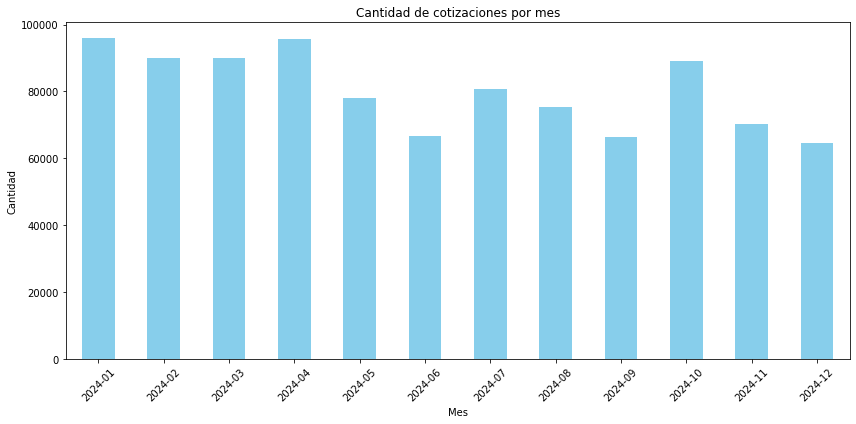

In [3]:
df_full["FECHA_COTIZACION"] = pd.to_datetime(df_full["FECHA_COTIZACION"])
df_full["MES"] = df_full["FECHA_COTIZACION"].dt.to_period("M")
conteo_mensual = df_full["MES"].value_counts().sort_index()
print(conteo_mensual)

import matplotlib.pyplot as plt

conteo_mensual.plot(kind="bar", figsize=(12, 6), color="skyblue")
plt.title("Cantidad de cotizaciones por mes")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Diagrama Posición Relativa.

POSICION_RELATIVA
0     399224
1      78587
2     148054
3     122086
4     104536
5      60579
6      32050
7      13562
8       3552
9        674
10        24
11         1
Name: count, dtype: int64


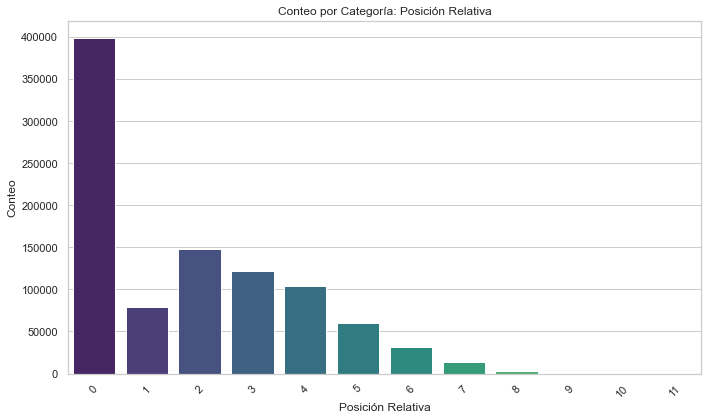

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de seaborn
sns.set(style="whitegrid")

# Contar las categorías
conteo = df_full['POSICION_RELATIVA'].value_counts().sort_index()
print(conteo)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x=conteo.index, y=conteo.values, palette='viridis')
plt.xlabel('Posición Relativa')
plt.ylabel('Conteo')
plt.title('Conteo por Categoría: Posición Relativa')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Diagramas Modalidades de Renta

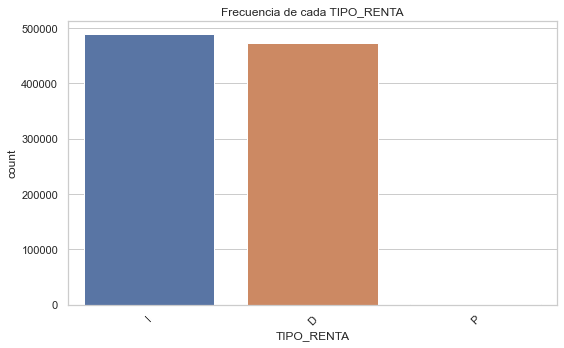

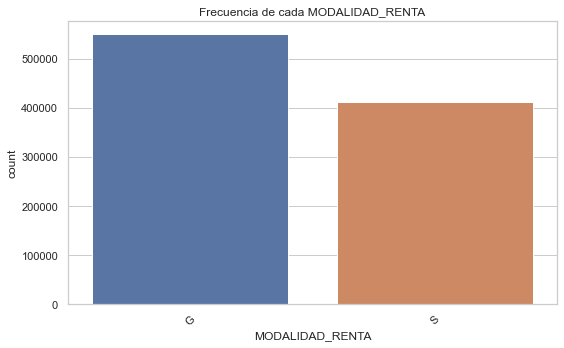

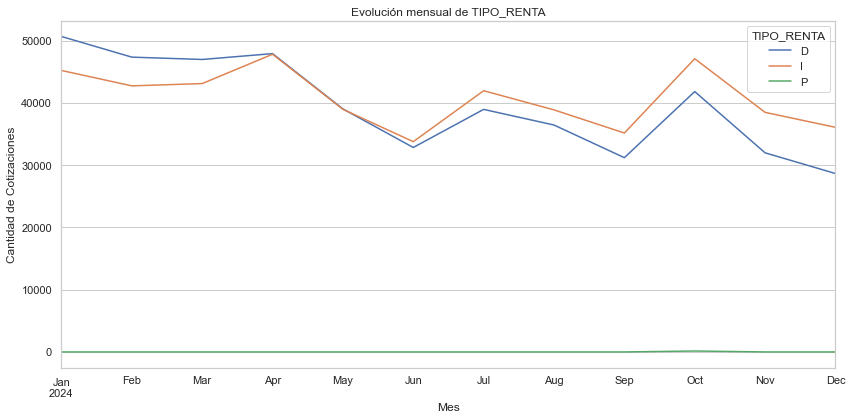

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que 'FECHA_COTIZACION' sea datetime
df_full['FECHA_COTIZACION'] = pd.to_datetime(df_full['FECHA_COTIZACION'], errors='coerce')

# Crear columna de mes
df_full['MES'] = df_full['FECHA_COTIZACION'].dt.to_period('M')

# --- Conteo absoluto de TIPO_RENTA ---
plt.figure(figsize=(8, 5))
sns.countplot(data=df_full, x='TIPO_RENTA', order=df_full['TIPO_RENTA'].value_counts().index)
plt.title('Frecuencia de cada TIPO_RENTA')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Conteo absoluto de MODALIDAD_RENTA ---
plt.figure(figsize=(8, 5))
sns.countplot(data=df_full, x='MODALIDAD_RENTA', order=df_full['MODALIDAD_RENTA'].value_counts().index)
plt.title('Frecuencia de cada MODALIDAD_RENTA')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Evolución mensual de TIPO_RENTA ---
tipo_renta_mes = df_full.groupby(['MES', 'TIPO_RENTA']).size().unstack(fill_value=0)

tipo_renta_mes.plot(figsize=(12, 6))
plt.title('Evolución mensual de TIPO_RENTA')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Cotizaciones')
plt.tight_layout()
plt.show()


### Matriz de Correlación

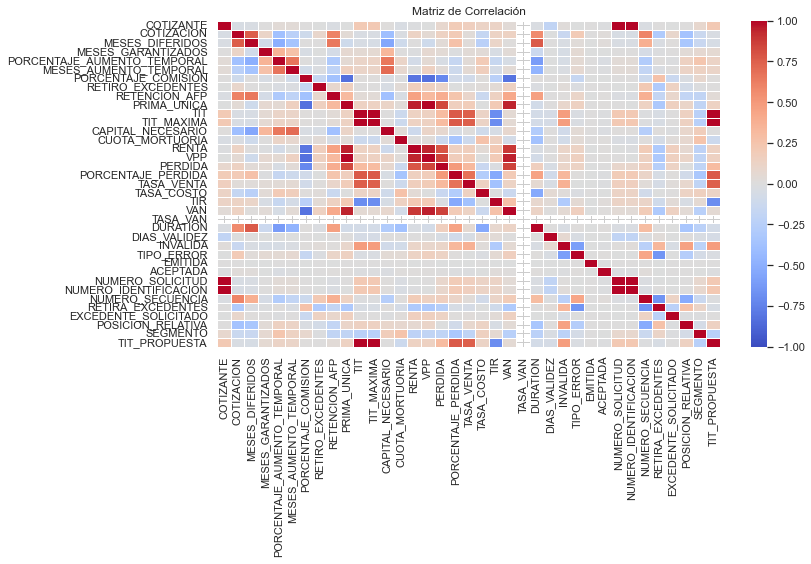

ACEPTADA                       1.000000
MESES_DIFERIDOS                0.021394
COTIZACION                     0.019235
TIR                            0.019028
NUMERO_SECUENCIA               0.016372
DURATION                       0.013756
RETENCION_AFP                  0.013288
CUOTA_MORTUORIA                0.011848
RENTA                          0.010990
VAN                            0.009457
PRIMA_UNICA                    0.008697
TIPO_ERROR                     0.008580
VPP                            0.008543
PERDIDA                        0.003789
RETIRO_EXCEDENTES              0.002325
EXCEDENTE_SOLICITADO           0.002036
POSICION_RELATIVA              0.000621
EMITIDA                       -0.000060
TASA_COSTO                    -0.000937
DIAS_VALIDEZ                  -0.002537
SEGMENTO                      -0.003711
MESES_GARANTIZADOS            -0.006850
PORCENTAJE_COMISION           -0.007477
RETIRA_EXCEDENTES             -0.007484
NUMERO_SOLICITUD              -0.007822


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionamos solo las columnas numéricas para calcular la correlación
df_numeric = df_full.select_dtypes(include=['number'])

# Calcular la matriz de correlación
corr_matrix = df_numeric.corr()

# Crear un mapa de calor sin los valores numéricos
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

# Calcular la correlación de todas las columnas con 'ACEPTADA'
corr_aceptada = df_numeric.corr()['ACEPTADA'].sort_values(ascending=False)

# Mostrar la correlación con 'ACEPTADA'
print(corr_aceptada)


### Analizamos cuántas cotizaciones se venden

In [48]:
print(df_full['ACEPTADA'].value_counts(dropna=False))

ACEPTADA
 0    962087
-1       842
Name: count, dtype: int64


Ventas en UF:

In [50]:
ventas_totales = df_full.loc[df_full['ACEPTADA'] == -1, 'PRIMA_UNICA'].sum()
print(f"Ventas totales en UF: {ventas_totales:,.2f} UF")

Ventas totales en UF: 1,362,285.77 UF


In [52]:
valor_uf = 39082 # 01/05
ventas_totales_pesos = ventas_totales * valor_uf
print(f"Ventas totales en pesos chilenos: ${ventas_totales_pesos:,.0f}")

tipo_cambio = 948  # 01/04
ventas_en_dolares = ventas_totales_pesos / tipo_cambio
print(f"Ventas totales en dólares: US${ventas_en_dolares:,.0f}")

Ventas totales en pesos chilenos: $53,240,852,463
Ventas totales en dólares: US$56,161,237


## Modelos Predictivos.

### Predicción Ranking con SC_Cotizaciones.

In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer

# --- Paso 1: Preparación de datos ---

# 1.1 Muestra de 10.000 filas
df_sample = df_sc #.sample(n=100000, random_state=42).copy()

# 1.2 Conversión de columnas numéricas con comas
cols_to_convert = [
    "COTIZACION", "RENTA", "PRIMA_UNICA", 
    "RETENCION_AFP", "RETIRO_EXCEDENTES", 
    "TIT_PROPUESTA", "TIT_MAXIMA", 
    "PORCENTAJE_COMISION"
]

for col in cols_to_convert:
    df_sample[col] = df_sample[col].astype(str).str.replace(',', '.', regex=False).astype(float)

# 1.3 Codificación de variables categóricas
categorical_cols = ["TIPO_RENTA", "MODALIDAD_RENTA", "SEGMENTO", "NOMBRE_SEGMENTO"]
df_sample[categorical_cols] = df_sample[categorical_cols].astype("category")

# One-hot encoding
df_encoded = pd.get_dummies(df_sample, columns=categorical_cols)

# 1.4 Features (X) y etiqueta (y)
X = df_encoded.drop(columns=["POSICION_RELATIVA", "FECHA_COTIZACION"])
y = df_sample["POSICION_RELATIVA"].astype(int)

# Guardar índice original antes de imputar
X["index_original"] = df_sample.index

# Imputación de NaN con la media
imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X.drop(columns=["index_original"])), columns=X.columns[:-1])
X_imputed["index_original"] = X["index_original"].values

# --- Paso 1.5: Filtrar clases con al menos 2 observaciones ---
conteo_clases = y.value_counts()
clases_validas = conteo_clases[conteo_clases >= 2].index

# Filtrar X e y con las clases válidas
filtro_validas = y.isin(clases_validas)
X_imputed = X_imputed[filtro_validas].reset_index(drop=True)
y = y[filtro_validas].reset_index(drop=True)


# --- Paso 2: Modelo de Random Forest ---

# 2.1 División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed.drop(columns=["index_original"]),
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

index_test = X_imputed.loc[X_test.index, "index_original"]

# 2.2 Entrenamiento
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)
clf.fit(X_train, y_train)

# 2.3 Evaluación
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# --- Paso 3: Resultados y exportación ---

# 3.1 Probabilidades por clase
y_prob = clf.predict_proba(X_test)
prob_df = pd.DataFrame(y_prob, columns=[f"proba_pos_{cls}" for cls in clf.classes_])
prob_df["prediccion"] = y_pred
prob_df["real"] = y_test.values
prob_df["index_original"] = index_test.values

# 3.2 Agregar columnas originales para análisis
original_test_data = df_sample.loc[prob_df["index_original"].values]
resultados_finales = pd.concat([original_test_data.reset_index(drop=True), prob_df.reset_index(drop=True)], axis=1)

# 3.3 Guardar CSV
resultados_finales.to_csv("predicciones_random_forest.csv", index=False)


c:\Users\nicol\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nicol\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nicol\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     79845
           1       0.67      0.70      0.68     15718
           2       0.64      0.71      0.67     29611
           3       0.56      0.54      0.55     24417
           4       0.59      0.57      0.58     20907
           5       0.53      0.50      0.51     12116
           6       0.54      0.48      0.51      6410
           7       0.54      0.48      0.51      2712
           8       0.54      0.36      0.43       710
           9       0.57      0.32      0.41       135
          10       0.00      0.00      0.00         5

    accuracy                           0.76    192586
   macro avg       0.56      0.51      0.53    192586
weighted avg       0.76      0.76      0.76    192586



In [18]:
resultados_finales.head()

,FECHA_COTIZACION,NUMERO_SOLICITUD,NUMERO_IDENTIFICACION,NUMERO_SECUENCIA,TIPO_RENTA,MESES_DIFERIDOS,MODALIDAD_RENTA,MESES_GARANTIZADOS,MESES_AUMENTO_TEMPORAL,PORCENTAJE_AUMENTO_TEMPORAL,...,proba_pos_4,proba_pos_5,proba_pos_6,proba_pos_7,proba_pos_8,proba_pos_9,proba_pos_10,prediccion,real,index_original
0,2024-06-13,132262802,195825026,1,I,0,G,240,84,100,...,0.57,0.07,0.01,0.0,0.01,0.0,0.0,4,3,480659
1,2024-12-02,137464902,201885839,2,D,60,S,0,0,0,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0,0,898908
2,2024-04-29,130793601,194128904,1,I,0,S,0,0,0,...,0.04,0.04,0.18,0.0,0.00,0.0,0.0,2,2,365176
3,2024-12-31,138286601,202793343,1,I,0,S,0,36,100,...,0.10,0.01,0.01,0.0,0.00,0.0,0.0,3,3,960341
4,2024-08-30,134861201,198568233,1,I,0,G,180,0,0,...,0.17,0.00,0.00,0.0,0.00,0.0,0.0,3,5,672365


### Predicción Probabilidad Venta con df_full

In [6]:
print(df_full['ACEPTADA'].value_counts(dropna=False))

ACEPTADA
 0    962087
-1       842
Name: count, dtype: int64


In [5]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# 1. Crear copia y limpiar datos
df_model = df_full.copy()

# 2. Filtrar target y convertirlo a 1 (aceptada) y 0 (no aceptada)
df_model = df_model[df_model['ACEPTADA'].isin([-1, 0])].copy()
df_model['TARGET'] = (df_model['ACEPTADA'] == -1).astype(int)

# 3. Seleccionar columnas numéricas
X = df_model.select_dtypes(include='number').drop(columns=['ACEPTADA', 'TARGET'])

# 4. Eliminar columnas con NaN o demasiados ceros (opcional)
X = X.dropna(axis=1)
y = df_model['TARGET']

# 5. Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Aplicar SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# 7. Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 8. Ajustar modelo con pesos balanceados
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 9. Predicciones y evaluación
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_proba):.3f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82    288818
           1       0.79      0.89      0.84    288435

    accuracy                           0.83    577253
   macro avg       0.83      0.83      0.83    577253
weighted avg       0.83      0.83      0.83    577253

AUC: 0.888


                        feature  coefficient
15             NUMERO_SECUENCIA   -23.590003
0                     COTIZANTE    23.182336
14        NUMERO_IDENTIFICACION   -21.748181
16            RETIRA_EXCEDENTES    -9.384204
17         EXCEDENTE_SOLICITADO    -3.123222
10                          TIR    -1.302694
13             NUMERO_SOLICITUD    -1.103543
18            POSICION_RELATIVA    -0.932168
2               MESES_DIFERIDOS    -0.884932
8                   PRIMA_UNICA    -0.544847
4   PORCENTAJE_AUMENTO_TEMPORAL     0.410028
1                    COTIZACION    -0.337760
19                     SEGMENTO    -0.313374
6           PORCENTAJE_COMISION    -0.245125
11                 DIAS_VALIDEZ     0.201777


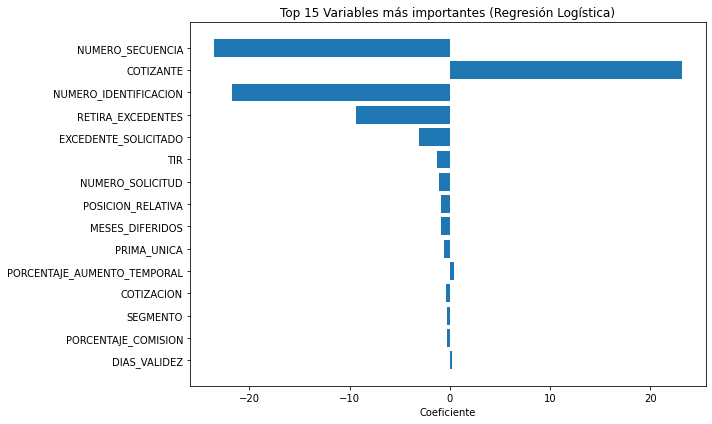

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Recuperar nombres de las variables
feature_names = X.columns  # sin escalar

# Obtener los coeficientes
coefs = model.coef_[0]

# Crear DataFrame con nombre y valor del coeficiente
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs,
    'abs_coefficient': np.abs(coefs)
})

# Ordenar por el valor absoluto del coeficiente
coef_df_sorted = coef_df.sort_values(by='abs_coefficient', ascending=False)

# Mostrar las 15 variables más importantes
print(coef_df_sorted[['feature', 'coefficient']].head(15))

# (Opcional) Visualización
plt.figure(figsize=(10, 6))
plt.barh(coef_df_sorted['feature'][:15], coef_df_sorted['coefficient'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Variables más importantes (Regresión Logística)")
plt.xlabel("Coeficiente")
plt.tight_layout()
plt.show()


In [8]:
y_pred_full = model.predict(X_scaled)
pd.Series(y_pred_full).value_counts().rename(index={0: 'No Aceptada', 1: 'Aceptada'})

No Aceptada    739004
Aceptada       223925
Name: count, dtype: int64

El modelo está rechazando todas las cotizaciones. Puede deberse a la gran asimetría de cantidad de datos entre las clases. EN la BBDD completa hay 842 cotizaciones ACEPTADAS y 962087 NO ACEPTADAS.

### Predicción de Ventas con Modelo.

In [10]:
# Volver a predecir sobre todos los datos (por ejemplo, en X_scaled)
y_pred_full = model.predict(X_scaled)

# Agregar las predicciones al DataFrame original
df_model['PREDICHA'] = y_pred_full

# Sumar PRIMA_UNICA donde la predicción sea 1 (es decir, aceptación)
prima_total_uf = df_model.loc[df_model['PREDICHA'] == 1, 'PRIMA_UNICA'].sum()

print(f"Prima total estimada (solo predicciones aceptadas): {prima_total_uf:.2f} UF")


uf_to_usd = 40.5

# Convertir la prima total de UF a dólares
prima_total_usd = prima_total_uf * uf_to_usd
print(f"Prima total estimada (en dólares): {prima_total_usd:.2f} USD")


Prima total estimada (solo predicciones aceptadas): 337306317.65 UF
Prima total estimada (en dólares): 13660905864.82 USD


### Probamos con XGBoost

In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ajuste de pesos de clase en XGBoost (aumento de peso en la clase minoritaria)
# Se calcula un valor aproximado de scale_pos_weight basado en el desbalance de clases
scale_pos_weight = (len(y_train) - sum(y_train == 1)) / sum(y_train == 1)

# Definir el modelo XGBoost con ajuste de pesos
model_xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')

# Entrenar el modelo
model_xgb.fit(X_train, y_train)

# Predicción
y_pred_xgb = model_xgb.predict(X_test)

# Evaluar el modelo
from sklearn.metrics import classification_report, accuracy_score

print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred_xgb))
print(f"Precisión: {accuracy_score(y_test, y_pred_xgb):.2f}")

# Obtener las probabilidades para ajustar el umbral si lo deseas
y_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Ajustar el umbral de decisión para XGBoost
umbral_xgb = 0.2  # Puedes probar diferentes umbrales
y_pred_xgb_ajustado = (y_proba_xgb > umbral_xgb).astype(int)

# Evaluar las métricas con el nuevo umbral
print(f"Precision: {accuracy_score(y_test, y_pred_xgb_ajustado):.2f}")
print("Reporte de Clasificación Ajustado:")
print(classification_report(y_test, y_pred_xgb_ajustado))

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    192413
           1       0.01      0.29      0.01       173

    accuracy                           0.96    192586
   macro avg       0.50      0.63      0.50    192586
weighted avg       1.00      0.96      0.98    192586

Precisión: 0.96
Precision: 0.91
Reporte de Clasificación Ajustado:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    192413
           1       0.01      0.51      0.01       173

    accuracy                           0.91    192586
   macro avg       0.50      0.71      0.48    192586
weighted avg       1.00      0.91      0.95    192586



In [13]:
# Predecir sobre todos los datos (por ejemplo, en X_scaled)
y_pred_full_xgb = model_xgb.predict(X_scaled)

# Ver la distribución de las predicciones (0: No Aceptada, 1: Aceptada)
pd.Series(y_pred_full_xgb).value_counts().rename(index={0: 'No Aceptada', 1: 'Aceptada'})

No Aceptada    926489
Aceptada        36440
Name: count, dtype: int64

In [14]:
# Agregar las predicciones al DataFrame original
df_model['PREDICHA_XGB'] = y_pred_full_xgb

# Sumar PRIMA_UNICA donde la predicción sea 1 (es decir, aceptación)
prima_total_uf_xgb = df_model.loc[df_model['PREDICHA_XGB'] == 1, 'PRIMA_UNICA'].sum()

print(f"Prima total estimada (solo predicciones aceptadas, XGBoost): {prima_total_uf_xgb:.2f} UF")

# Definir la tasa de conversión de UF a USD
uf_to_usd = 40.5

# Convertir la prima total de UF a dólares
prima_total_usd_xgb = prima_total_uf_xgb * uf_to_usd
print(f"Prima total estimada (en dólares, XGBoost): {prima_total_usd_xgb:.2f} USD")

Prima total estimada (solo predicciones aceptadas, XGBoost): 49458207.53 UF
Prima total estimada (en dólares, XGBoost): 2003057404.96 USD
